# Notebook for minimal experiments and setup checks

## Training Workflow: Joint Optimization with Feedback

**Input:** Audio Chunks + Text/Speech Targets  
&nbsp;&nbsp;&nbsp;&nbsp;↓  
**Chunked Audio Preprocessing**  
&nbsp;&nbsp;&nbsp;&nbsp;2s chunks, 0.5s overlap to simulate streaming  
&nbsp;&nbsp;&nbsp;&nbsp;↓  
**Shared Encoder** (SeamlessM4T / Wav2Vec2)  
&nbsp;&nbsp;&nbsp;&nbsp;↓  
**Acoustic Features**  
&nbsp;&nbsp;&nbsp;&nbsp;├────────────┬──────────────┐  
&nbsp;&nbsp;&nbsp;&nbsp;↓&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;↓&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;↓  
**Text Decoder**  **Speech Decoder**  **Context Buffer**  
(S2T Path)      (S2S Path)       (Stores recent chunks)  
&nbsp;&nbsp;&nbsp;&nbsp;↓          ↓  
Text Output     Speech Units  
&nbsp;&nbsp;&nbsp;&nbsp;|          ↓  
&nbsp;&nbsp;&nbsp;&nbsp;|        **[Neural Vocoder]**  
&nbsp;&nbsp;&nbsp;&nbsp;|          ↓  
&nbsp;&nbsp;&nbsp;&nbsp;|       Synthesized Audio  
&nbsp;&nbsp;&nbsp;&nbsp;|          ↓  
&nbsp;&nbsp;&nbsp;&nbsp;└───────────┬───────────┘  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;      ↓  

### Feedback Mechanism 1 — Semantic Consistency Check
- Run ASR on synthesized audio  
- Compare with text output  
- Compute similarity loss

### Feedback Mechanism 2 — Confidence Estimation
- Extract prediction scores  
- Estimate model uncertainty  

### Combined Loss Function

$$
\text{Total Loss} = L_{\text{text}} + L_{\text{speech}} + \lambda_1 L_{\text{consistency}} + \lambda_2 L_{\text{confidence}}
$$


### Backpropagation
Update all components jointly
  (Encoder, Decoders, Vocoder, Feedback modules)


## Inference Mode: Streaming with Adaptive Feedback

**Live Microphone** or **Streaming Audio File**  
&nbsp;&nbsp;&nbsp;&nbsp;↓ (continuous stream)  
**Audio Buffer Manager**  
&nbsp;&nbsp;&nbsp;&nbsp;Accumulates audio in overlapping chunks  
&nbsp;&nbsp;&nbsp;&nbsp;Chunk: 2.0s, Hop: 0.5s  
&nbsp;&nbsp;&nbsp;&nbsp;↓  
Every 0.5s, new chunk available  
**Chunk Queue** ← maintains last 3–4 chunks for context  
&nbsp;&nbsp;&nbsp;&nbsp;↓  
Process immediately (Similar to Wait-K)

**Shared Encoder**  
&nbsp;&nbsp;&nbsp;&nbsp;↓  
Features extracted   
&nbsp;&nbsp;&nbsp;&nbsp;├────────────────────┬─────────────────┐  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;↓&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;↓&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;↓  
**Text Decoder**  **Speech Decoder**  **Confidence Estimator**  
(S2T Path)      (S2S Path)       (Estimates reliability)  
&nbsp;&nbsp;&nbsp;&nbsp;↓&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;                    ↓     &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;            ↓  
Text (partial)&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Speech Units  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Confidence Score  
&nbsp;&nbsp;&nbsp;&nbsp;|                |  
&nbsp;&nbsp;&nbsp;&nbsp;|                ↓  
&nbsp;&nbsp;&nbsp;&nbsp;|           &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Vocoder**  
&nbsp;&nbsp;&nbsp;&nbsp;|              &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;↓  
&nbsp;&nbsp;&nbsp;&nbsp;|           &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Audio Output  
&nbsp;&nbsp;&nbsp;&nbsp;|              &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;↓  
&nbsp;&nbsp;&nbsp;&nbsp;└───────────────────────┬───────────────────┘  
&nbsp;&nbsp;&nbsp;&nbsp;         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;↓  

### Adaptive Decision Gate
- **High Confidence (> 0.90):**  
  Emit immediately
  Play audio + display text   

- **Medium Confidence (0.75–0.90):**  
  Wait for 1 more chunk  
  Re-process with more context

- **Low Confidence (< 0.75):**  
  Buffer 2–3 more chunks  
  Re-process with extended context  


### Feedback Verification *(optional for high-quality mode)*
- Run ASR on output audio  
- Check semantic match with text  
- Flag if mismatch detected  

### Output Emission
- Play synthesized speech  
- Display text translation  
- Log confidence + similarity metrics  

### Boundary Detection
- Silence detected → Reset context buffer  
- Punctuation in text → Segment boundary  
- Confidence drop → Potential speaker change  

Loop back to **Audio Buffer Manager**  
*(Next chunk ready every 0.5 s)*


# Install dependencies

In [ ]:
!pip install -U openai-whisper

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.2/803.2 kB 13.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for openai-whisper: filename=openai_whisper-20250625-py3-none-any.whl size=803979 sha256=6e0c8ad889a42abb1338529647f88871fc0ca76c99f20c6c86c776fdd2984f28
  Stored in directory: /root/.cache/pip/wheels/61/d2/20/09ec9bef734d126cba375b15898010b6cc28578d8afdde5869
Successfully built openai-whisper


In [ ]:
!pip install git+https://github.com/huggingface/transformers.git sentencepiece

  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-seo3rbzp
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-seo3rbzp
  Resolved https://github.com/huggingface/transformers.git to commit 02c324f43fe0ef5d484e846417e5f3bf4484524c
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 502.0/502.0 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 3.1 MB/s eta 0:00:00
  Created wheel for transformers: filename=transformers-5.0.0.dev0-py3-none-any.whl size=11349332 sha256=d7ec57dd5e8a8037967e8ab2a321454a340b419f8c1ba1115a29fd6ddbd76630
  Stored in directory: /tmp/pip-ephem-wheel-cache-82exeg15/wheels/54/cb/3f/83103de5575c534436d6a4686686dead458238dfaf1147e98d
Successfully built transformers
  Attempting uninstall: huggingface-hub
    Foun

In [ ]:
!pip install -q transformers>=4.35.0 datasets soundfile librosa torch torchaudio accelerate sentencepiece jiwer matplotlib scikit-learn scipy

# Code

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Load Dataset

In [ ]:
# Load dataset
import os
import tarfile
input_path_src = '/content/drive/My Drive/cvss_c_cy_en_v1.0.tar.gz'
input_path_tgt = '/content/drive/My Drive/cv-corpus-22.0-2025-06-20.gz'
extract_directory_src = '/content/src_dataset'
extract_directory_tgt = '/content/tgt_dataset'
os.makedirs(extract_directory_src, exist_ok=True)
os.makedirs(extract_directory_tgt, exist_ok=True)

with tarfile.open(input_path_src, 'r:gz') as tar:
    tar.extractall(extract_directory_src)

with tarfile.open(input_path_tgt, 'r:gz') as tar:
    tar.extractall(extract_directory_tgt)

print('Extracted files successfully')

/tmp/ipython-input-586041448.py:12: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(extract_directory_src)
/tmp/ipython-input-586041448.py:15: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(extract_directory_tgt)


Extracted files successfully


### EDA on Dataset

In [ ]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
from IPython.display import Audio
import glob
import warnings
warnings.filterwarnings('ignore')


In [ ]:
# Structure of dataset
audio_path_tgt = None

# Source audio
print('Source dataset structure :')
for root, dirs, files in os.walk(extract_directory_src):
    print(root, "===", len(files), 'files')

# Target audio
print('\nTarget dataset structure :')
for root, dirs, files in os.walk(extract_directory_tgt):
    print(root, "===", len(files), 'files')
    if os.path.basename(root) == 'cy':
      audio_path_tgt = root

Source dataset structure :
/content/src_dataset === 3 files
/content/src_dataset/dev === 688 files
/content/src_dataset/train === 1241 files
/content/src_dataset/test === 690 files

Target dataset structure :
/content/tgt_dataset === 0 files
/content/tgt_dataset/cv-corpus-22.0-2025-06-20 === 0 files
/content/tgt_dataset/cv-corpus-22.0-2025-06-20/cy === 10 files
/content/tgt_dataset/cv-corpus-22.0-2025-06-20/cy/clips === 115915 files


In [ ]:
# Total audio files
audio_files_src = glob.glob(os.path.join(extract_directory_src, '**/*.wav'), recursive = True)
audio_files_tgt = glob.glob(os.path.join(extract_directory_tgt, '**/*.mp3'), recursive = True)
print(f'{len(audio_files_src)} English audio found')
print(f'{len(audio_files_tgt)} Welsh audio found')

2619 English audio found
115915 Welsh audio found


In [ ]:
# Metadata from audio files
metadata_src, metadata_tgt = [], []

for audio in audio_files_src[:100]:
  y, sr = librosa.load(audio, sr = None)
  duration = librosa.get_duration(y=y, sr=sr)
  metadata_src.append({'path': audio, 'duration': duration, 'sr' : sr})
source = pd.DataFrame(metadata_src)

for audio in audio_files_tgt[:100]:
  y, sr = librosa.load(audio, sr = None)
  duration = librosa.get_duration(y=y, sr=sr)
  metadata_tgt.append({'path': audio, 'duration': duration, 'sr' : sr})
target = pd.DataFrame(metadata_tgt)

In [ ]:
display(source.head())
display(target.sample(5))

,path,duration,sr
0,/content/src_dataset/dev/common_voice_cy_18995...,2.0875,24000
1,/content/src_dataset/dev/common_voice_cy_18114...,3.0500,24000
2,/content/src_dataset/dev/common_voice_cy_18995...,3.8125,24000
3,/content/src_dataset/dev/common_voice_cy_18280...,3.3625,24000
4,/content/src_dataset/dev/common_voice_cy_17678...,2.2125,24000


,path,duration,sr
13,/content/tgt_dataset/cv-corpus-22.0-2025-06-20...,2.280,48000
14,/content/tgt_dataset/cv-corpus-22.0-2025-06-20...,2.904,48000
53,/content/tgt_dataset/cv-corpus-22.0-2025-06-20...,3.192,48000
78,/content/tgt_dataset/cv-corpus-22.0-2025-06-20...,3.144,48000
98,/content/tgt_dataset/cv-corpus-22.0-2025-06-20...,1.440,48000


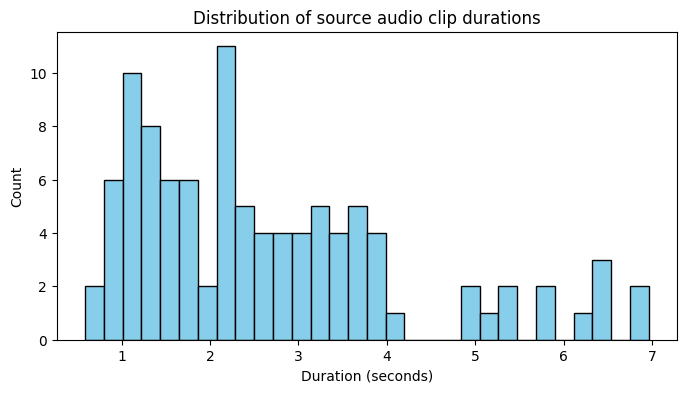

count    100.000000
mean       2.662375
std        1.553387
min        0.587500
25%        1.393750
50%        2.268750
75%        3.375000
max        6.962500
Name: duration, dtype: float64


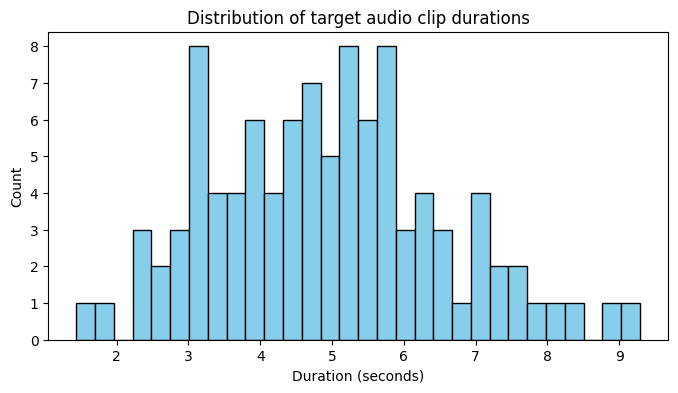

count    100.000000
mean       4.925594
std        1.598086
min        1.440000
25%        3.735347
50%        4.896000
75%        5.811000
max        9.288000
Name: duration, dtype: float64


In [ ]:
# Duration distribution
plt.figure(figsize=(8, 4))
plt.hist(source['duration'], bins=30, color='skyblue', edgecolor='black')
plt.xlabel("Duration (seconds)")
plt.ylabel("Count")
plt.title("Distribution of source audio clip durations")
plt.show()
print(source['duration'].describe())

plt.figure(figsize=(8, 4))
plt.hist(target['duration'], bins=30, color='skyblue', edgecolor='black')
plt.xlabel("Duration (seconds)")
plt.ylabel("Count")
plt.title("Distribution of target audio clip durations")
plt.show()
print(target['duration'].describe())

In [ ]:
# Transcripts analysis
text_files_src = glob.glob(os.path.join(extract_directory_src, '**/*.tsv'), recursive=True)
text_files_tgt = glob.glob(os.path.join(extract_directory_tgt, '**/*.tsv'), recursive=True)
print(f'{len(text_files_src)} source transcript files found')
print(f'{len(text_files_tgt)} target transcript files found')

3 source transcript files found
10 target transcript files found


In [ ]:
texts_src, texts_tgt = [], []
for file in text_files_src:
  tsv_df = pd.read_csv(file, sep='\t', header = None)
  texts_src.append(tsv_df)
df_text_src = pd.concat(texts_src, ignore_index=True)

for file in text_files_tgt:
  tsv_df = pd.read_csv(file, sep = '\t')
  texts_tgt.append(tsv_df)
df_text_tgt = pd.concat(texts_tgt, ignore_index=True)

In [ ]:
display(df_text_src.head())
display(df_text_tgt.head())

,0,1
0,common_voice_cy_17301829.mp3,i need soap please
1,common_voice_cy_17301830.mp3,what time will he start
2,common_voice_cy_17301835.mp3,where do you live
3,common_voice_cy_17301844.mp3,ifan huw dafydd iwan llwyd john pierce jones
4,common_voice_cy_17301845.mp3,what is islam


,client_id,path,sentence_id,sentence,sentence_domain,up_votes,down_votes,age,gender,accents,variant,locale,segment,source,is_used,clips_count,reason,clip,duration[ms]
0,c55e72b79868a23fb9dbce25b6bd069591664ef440998b...,common_voice_cy_24396707.mp3,396a06608e3d24619467dce105192f523b86afc2a03547...,Ond mae rhywun annisgwyl yno i achub y dydd.,NaN,2.0,0.0,NaN,NaN,NaN,NaN,cy,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,c55e72b79868a23fb9dbce25b6bd069591664ef440998b...,common_voice_cy_24396709.mp3,25c8f5a10258059f3bde509e8c3b10c31b4deefe2d1b39...,Comedi afreolus am ddireidi ynfyd criw o gymer...,NaN,2.0,0.0,NaN,NaN,NaN,NaN,cy,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,c55e72b79868a23fb9dbce25b6bd069591664ef440998b...,common_voice_cy_24396710.mp3,28b1ac50302ececb23e796bc9c84859e0f2abfc9a4be2a...,"Mewn triongl aflem, mae un o'r onglau mewnol y...",NaN,2.0,1.0,NaN,NaN,NaN,NaN,cy,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,c55e72b79868a23fb9dbce25b6bd069591664ef440998b...,common_voice_cy_24396711.mp3,336f155c79abb578afb079088c40456d5c99a4773d32a9...,Stori gan Rhiannon Wyn yw Yr Alarch Du.,NaN,2.0,0.0,NaN,NaN,NaN,NaN,cy,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,c55e72b79868a23fb9dbce25b6bd069591664ef440998b...,common_voice_cy_24396717.mp3,3e46ecf5e7ab6a135fe464be99396439c664386168f86c...,"Mae'n hedfan mewn un genhedlaeth yn unig, rhwn...",NaN,2.0,0.0,NaN,NaN,NaN,NaN,cy,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_text_tgt['sentence'].fillna('', inplace=True)
df_text_tgt['word_count'] = df_text_tgt['sentence'].fillna('').apply(lambda x: len(x.split()))
df_text_tgt['char_count'] = df_text_tgt['sentence'].fillna('').apply(len)

df_text_src[1].fillna('', inplace=True)
df_text_src['word_count'] = df_text_src[1].fillna('').apply(lambda x: len(x.split()))
df_text_src['char_count'] = df_text_src[1].fillna('').apply(len)

          word_count     char_count
count  368804.000000  368804.000000
mean        6.398724      36.243238
std         5.467866      45.949959
min         0.000000       0.000000
25%         0.000000       0.000000
50%         7.000000      41.000000
75%        11.000000      60.000000
max       936.000000   15644.000000


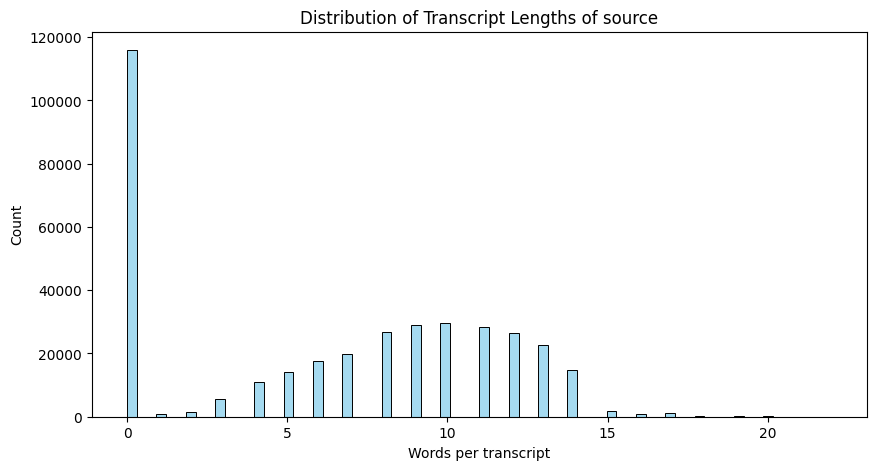

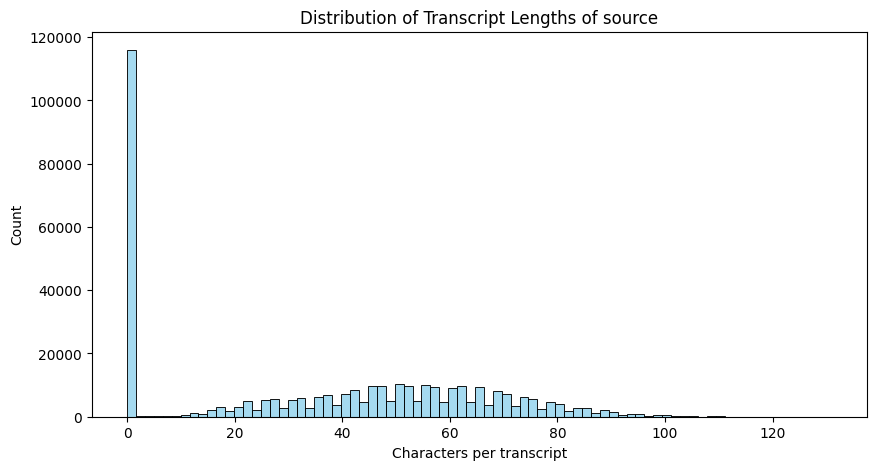

In [ ]:
cols = ['sentence', 'word_count', 'char_count']
df_text_analysis = df_text_tgt[cols]
# Check distribution before removing outliers
print(df_text_analysis[['word_count', 'char_count']].describe())

# Remove outliers
Q1_wc = df_text_analysis['word_count'].quantile(0.25)
Q3_wc = df_text_analysis['word_count'].quantile(0.75)
IQR_wc = Q3_wc - Q1_wc
lower_wc = Q1_wc - 1.5 * IQR_wc
upper_wc = Q3_wc + 1.5 * IQR_wc

Q1_cc = df_text_analysis['char_count'].quantile(0.25)
Q3_cc = df_text_analysis['char_count'].quantile(0.75)
IQR_cc = Q3_cc - Q1_cc
lower_cc = Q1_cc - 1.5 * IQR_cc
upper_cc = Q3_cc + 1.5 * IQR_cc

# Filter out both word_count and char_count outliers
df_text_analysis = df_text_analysis[(df_text_analysis['word_count'].between(lower_wc, upper_wc)) & (df_text_analysis['char_count'].between(lower_cc, upper_cc))]

# Distribution of transcript lengthof source
plt.figure(figsize=(10, 5))
sns.histplot(df_text_analysis, x='word_count', color='skyblue', edgecolor='black')
plt.xlabel('Words per transcript')
plt.ylabel('Count')
plt.title('Distribution of Transcript Lengths of source')
plt.show()

# Distribution of transcript char length of source
plt.figure(figsize=(10, 5))
sns.histplot(df_text_analysis, x='char_count', color='skyblue', edgecolor='black')
plt.xlabel('Characters per transcript')
plt.ylabel('Count')
plt.title('Distribution of Transcript Lengths of source')
plt.show()


        word_count   char_count
count  2619.000000  2619.000000
mean      8.239786    42.498664
std       3.740709    20.006309
min       1.000000     2.000000
25%       5.000000    25.500000
50%       8.000000    43.000000
75%      11.000000    57.000000
max      24.000000   109.000000


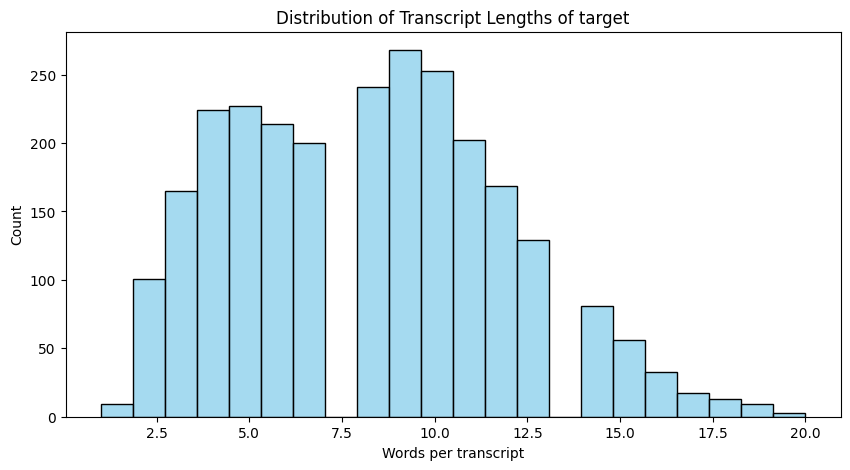

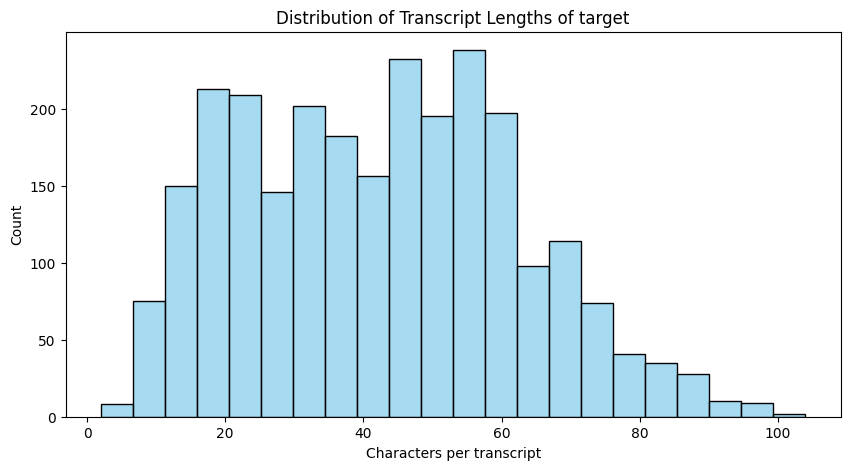

In [ ]:
# Check distribution before removing outliers
print(df_text_src[['word_count', 'char_count']].describe())

# Remove outliers
Q1_wc = df_text_src['word_count'].quantile(0.25)
Q3_wc = df_text_src['word_count'].quantile(0.75)
IQR_wc = Q3_wc - Q1_wc
lower_wc = Q1_wc - 1.5 * IQR_wc
upper_wc = Q3_wc + 1.5 * IQR_wc

Q1_cc = df_text_src['char_count'].quantile(0.25)
Q3_cc = df_text_src['char_count'].quantile(0.75)
IQR_cc = Q3_cc - Q1_cc
lower_cc = Q1_cc - 1.5 * IQR_cc
upper_cc = Q3_cc + 1.5 * IQR_cc

# Filter out both word_count and char_count outliers
df_text_src = df_text_src[(df_text_src['word_count'].between(lower_wc, upper_wc)) & (df_text_src['char_count'].between(lower_cc, upper_cc))]

# Distribution of transcript length of target
plt.figure(figsize=(10, 5))
sns.histplot(df_text_src, x='word_count', color='skyblue', edgecolor='black')
plt.xlabel('Words per transcript')
plt.ylabel('Count')
plt.title('Distribution of Transcript Lengths of target')
plt.show()

# Distribution of transcript char length of target
plt.figure(figsize=(10, 5))
sns.histplot(df_text_src, x='char_count', color='skyblue', edgecolor='black')
plt.xlabel('Characters per transcript')
plt.ylabel('Count')
plt.title('Distribution of Transcript Lengths of target')
plt.show()

In [ ]:
sample_audio = audio_files_src[0]
print('Sample audio : ', sample_audio)
Audio(sample_audio)

Sample audio :  /content/src_dataset/dev/common_voice_cy_18995841.mp3.wav


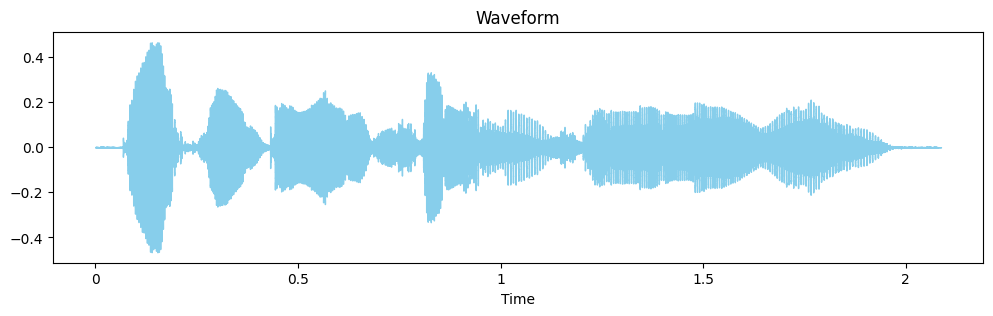

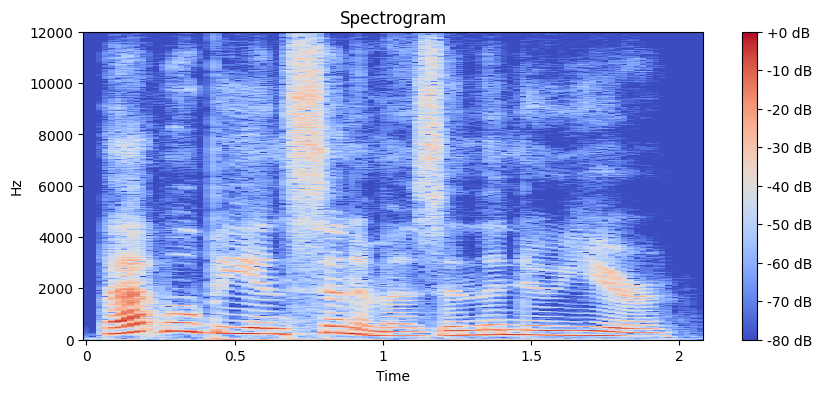

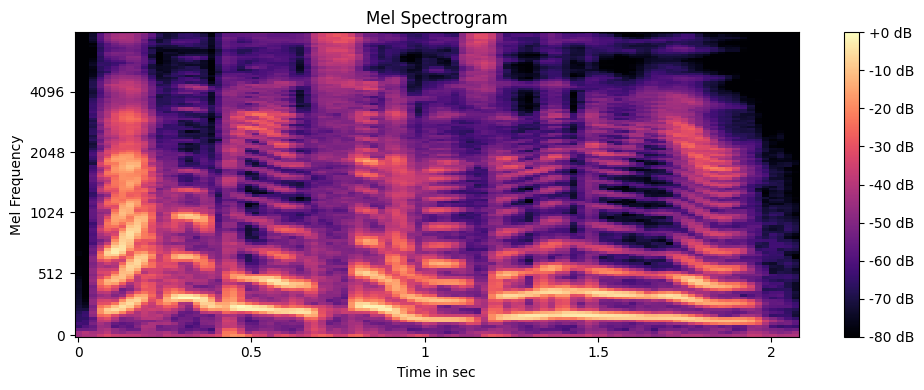

In [ ]:
y, sr = librosa.load(sample_audio, sr=None)

# Waveform
plt.figure(figsize=(12, 3))
librosa.display.waveshow(y, sr=sr, color='skyblue')
plt.title('Waveform')
plt.show()

# Spectrogram
D = np.abs(librosa.stft(y))**2
S_db = librosa.power_to_db(D, ref=np.max)
plt.figure(figsize=(10, 4))
librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='hz', cmap='coolwarm')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')

# Mel Spectrogram
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
S_dB = librosa.power_to_db(S, ref=np.max)
plt.figure(figsize=(10, 4))
librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel', fmax=8000, cmap='magma')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')
plt.xlabel('Time in sec')
plt.ylabel('Mel Frequency')
plt.tight_layout()
plt.show()